# Lab 4 : Non-negative Matrix Factorization

The goal of this lab session is to code a NMF algorithm and use it in some applications.


We begin with the standard imports:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_context('poster')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}

# NMF - Recap

Non-negative Matrix Factorization is a model where a matrix X is factorized into two matrices W and H, with the property that all three matrices have no negative elements. This non-negativity makes the resulting matrices easier to interpret.


Loss (Regularized Froebnius): $\mathcal{L}(W, H) = \frac{1}{2}\|X-W H\|_{F}^{2}+ \color{red}{\frac{\mu}{2}\|H\|_{F}^{2}+\lambda\|H\|_{1}+\frac{\nu}{2}\|W\|_{F}^{2}}$

Algorithm (multiplicative updates from [Lee and Seung, 1999] (http://papers.nips.cc/paper/1861-algorithms-for-non-negative-matrix-factorization.pdf)

\begin{array}{c}
W \leftarrow W .* \left(X H^T\right)./W \left(H H^{\top} + {\color{red} \nu I_r}\right) \\
H \leftarrow H .* \left(W^{\top} X - {\color{red} \lambda 1_{r \times n}}\right)./\left((W^{\top} W + {\color{red} \mu I_r})H\right)
\end{array}


.* is the dot product ( in python  : A*B ) 

AB is the matrix product ( in python : A@B )

## Initialization 

The computation time and the convergence of the NMF depends on how you initialize the matrices W and H.
You will implement and compare two types of initialization. 

#### Random initialization : 

$\forall i,j, H^0_{i,j}\sim U_{[0,1]}$ and $ W^0_{i,j}\sim U_{[0,1]} $

Each term of $W^0$ and $H^0$ is sampled with a uniform distribution. Use np.random.random(Matrix_shape)

#### NNDSVD initialization : 

Singular value decomposition (SVD) is a classical method that extends the eigen-decomposition to non-square matrix.

For any $ X \in \mathbb{R}^{N\times M}$, there exists a factorization with the following form:

$$ X = U \Sigma V^T $$

With $ U \in \mathbb{R}^{N\times N} , \Sigma  \in \mathbb{R}^{N\times M} \text{ such as } \Sigma = \begin{pmatrix} 
\Sigma_1 & 0 \\
0 & 0 
\end{pmatrix} , V \in \mathbb{R}^{M\times M} $



$\Sigma_1 = diag(σ1, σ2, ..., σr)$, and the diagonal entries are sorted in descending order, i.e. σ1 ≥ σ2 ≥ ... ≥ σr > 0,
σi, i = 1, 2, ...r being the singular values with r = rank(Z)


After the computation of the SVD of X, the initialization of W and H is made with  

$$ W^0 = |U_{:,:r}|$$
$$ H^0 = | \Sigma_{:r,:}V^T| $$ 
$|.|$ means the absolute value for each term of the matrix, r = number of components of the NMF :

You will need : 
np.linalg.svd 

Watch out np.linalg.svd returns only the diagonal of $\Sigma$. I advise you ton create a empty matrix $\Sigma$ with np.zeros(Shape of the matrix) then fill the diagonal with np.diag(). You can use the exemple in https://numpy.org/doc/stable/reference/generated/numpy.linalg.svd.html



### Tasks  :  
- Fill the fit transform function. Consider $\mathcal{L}(W, H) = \frac{1}{2}\|X-W H\|_{F}^{2}$ (no regularization)
- Implement NNSVD initialization and random initialization. 
- Return W H and the Froebenius norm of the residuals (the loss) when the convergence condition is fulfilled.

(This should take you less than 30 minutes)

In [2]:
class my_NMF():
    
    def __init__(self, n_components, epsilon,init, max_iter = 60):
        '''
        Attributes:
        
        n_components_ : integer
            the unknown dimension of W and H
        max_iter_: integer
            maximum number of iterations
        epsilon_ : float
        init_ :  {"random", "NNDSVD"}
        w_: np.array
            W Matrix factor
        H_: np.array
            H Matrix factor
        '''
        self.n_components = n_components
        self.max_iter = max_iter
        self.epsilon = epsilon
        self.init = init
        self.W = None
        self.H = None
        
        
    def fit_transform(self, X):
        """ Find the factor matrices W and H
        
        Parameters:
        -----------
        X: (n, p) np.array
            Data matrix
        
        Returns:
        -----
        W,H,loss
        """        


        
        
        if self.init == 'NNDSVD' :  
            #TODO
            #Initialize W and H with a SVD of X
            u, s, vh = np.linalg.svd(X, full_matrices=True)
            q=np.shape(np.diag(s))
            d=np.zeros(np.shape(X))
            d[:q[0],:q[1]]=np.diag(s)
            
            self.W=u[:,:self.n_components]
            self.H=d[:self.n_components,:]@vh
        elif self.init == 'random' :
            #TODO
            #Initialize W and H by generating uniform samples.
            self.W=np.random.random((X.shape[0], self.n_components))
            self.H=np.random.random((self.n_components,X.shape[1]))
        
        convergence = False 
        count=0
        
        while not(convergence): 
            if count == self.max_iter:
                break
            #The convergence is reached when the number of iteration is equal to self.max_iter or
            #when the loss < self.epsilon
            
            #𝑊.∗(𝑋𝐻𝑇)./𝑊(𝐻𝐻⊤)
            #𝐻←𝐻.∗(𝑊⊤𝑋)./((𝑊⊤𝑊)𝐻)
            #TODO 
            #Update W and H for each iteration
            self.W=self.W*((X@np.transpose(self.H))/(self.W@self.H@np.transpose(self.H)))
            self.H=self.H*((np.transpose(self.W)@X)/(np.transpose(self.W)@self.W@self.H))
            count+=1
            loss = np.linalg.norm(X-self.W@self.H,2)
            if loss < self.epsilon:
                break
            
        return self.W,self.H,loss


### Bonus : Implement the regularized version

## Applications

### First application - Images

For the first application you are going to analyse the following data to give an interpretation of the factorization:

array([0.76859504, 0.75619835, 0.74380165, ..., 0.48347107, 0.6280992 ,
       0.6528926 ], dtype=float32)

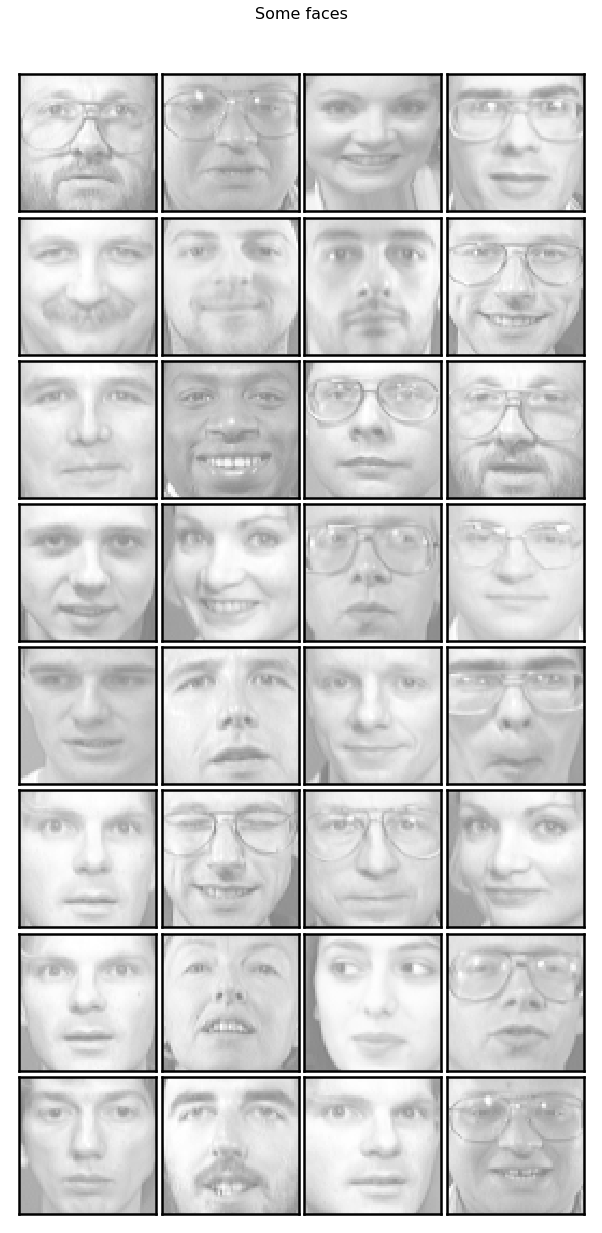

In [102]:
from sklearn.datasets import fetch_olivetti_faces

dataset = fetch_olivetti_faces(shuffle=True)

faces = dataset.data
image_shape = (64, 64)

n_samples, n_features = faces.shape

def plot_faces(title, images, image_shape, n_col=4, n_row=8, cmap=plt.cm.gray):
    plt.figure(figsize=(2. * n_col, 2.26 * n_row))
    plt.suptitle(title, size=16)
    for i, comp in enumerate(images):
        plt.subplot(n_row, n_col, i + 1)
        vmax = max(comp.max(), -comp.min())
        plt.imshow(comp.reshape(image_shape), cmap=cmap,
                   interpolation='nearest',
                   vmin=-vmax, vmax=vmax)
        plt.xticks(())
        plt.yticks(())
    plt.subplots_adjust(0.01, 0.05, 0.99, 0.93, 0.04, 0.)
    
plot_faces("Some faces", faces[:32], image_shape)

faces.shape
faces[1]

we are appliing the inverted algorithm since the number of faces are 400 and the number of pixel pae faces are 4096 when we apply fit transform my w will be h and vieversa

In [103]:
np.shape(faces)

(400, 4096)

### Task : apply your NMF algorithm to this dataset and plot some approximated face pictures. Compare the different initializations

means that there are 32 main facial features 

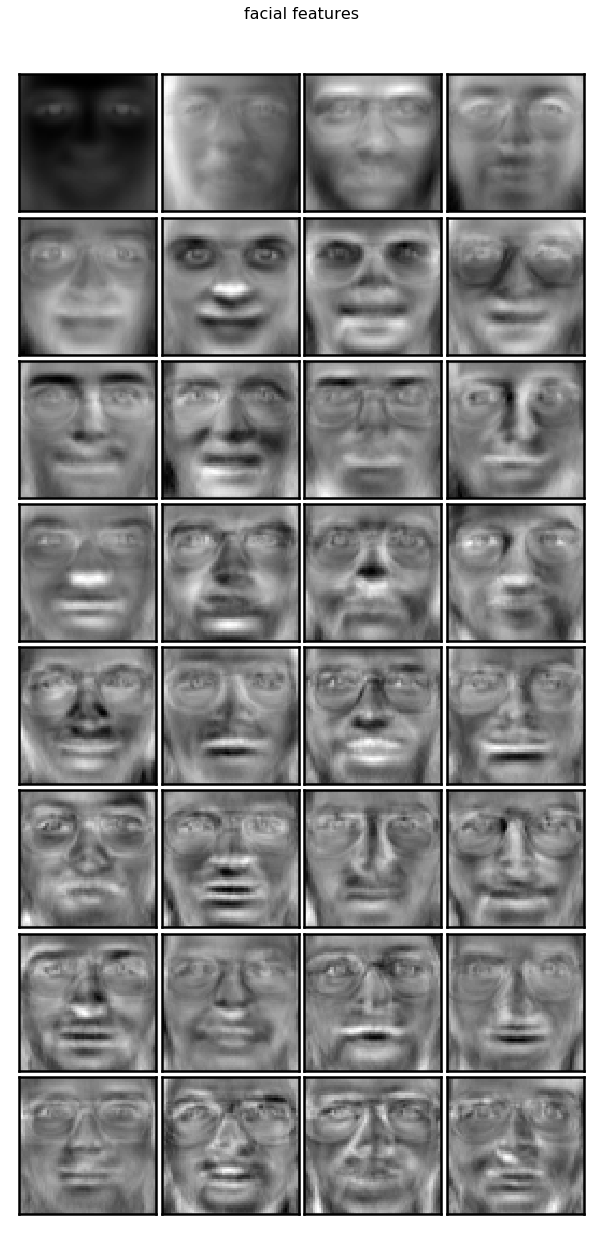

In [112]:
# with nndsvd initalizaion
a= my_NMF(n_components=32,epsilon=1,init='NNDSVD')
b= a.fit_transform(faces)

image_shape=(64,64)
plot_faces("facial features", b[1], image_shape)

In [104]:
np.shape(b[1]) #means that there are 32 main facial features (each feature is an image 64x64(since has dimension p)) my vector W in the theory

(32, 4096)

this means how each facial feature is weighted in image i, 

In [106]:
np.shape(b[0]) #this means how each facial feature is weighted in image i 

(400, 32)

In [107]:
a=b[0]@b[1]

here are the the approximated first 32 faces 

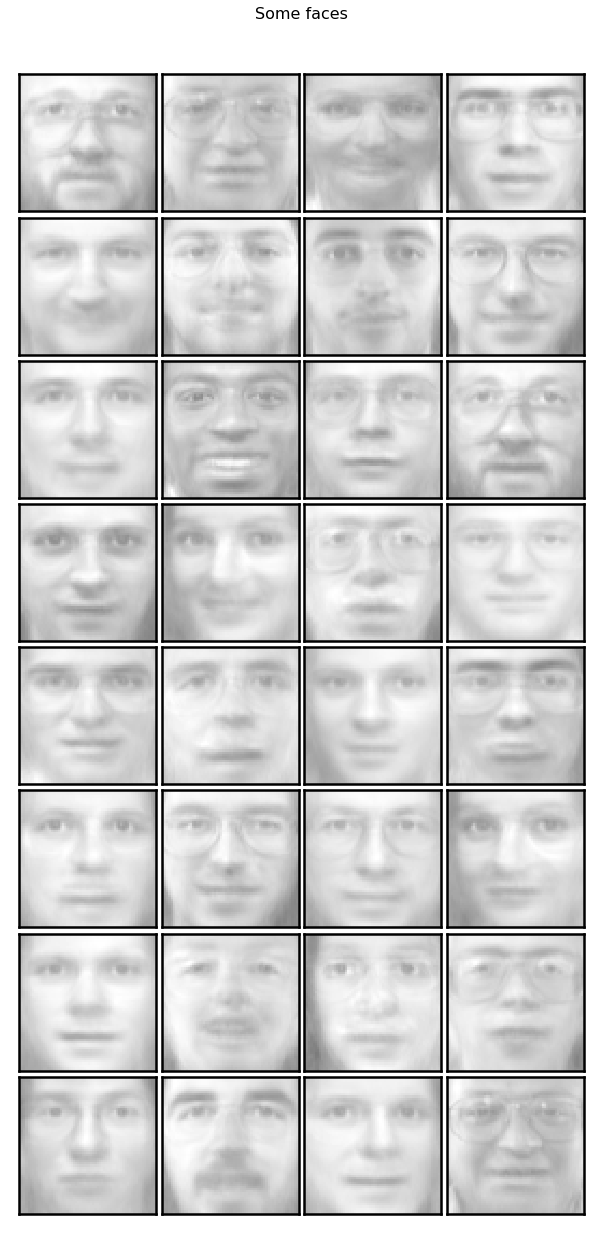

In [111]:
plot_faces("Some faces", a[:32], image_shape)

here is the final loss

In [113]:
b[2]

10.809244828893728

lets now try with a random initialization 

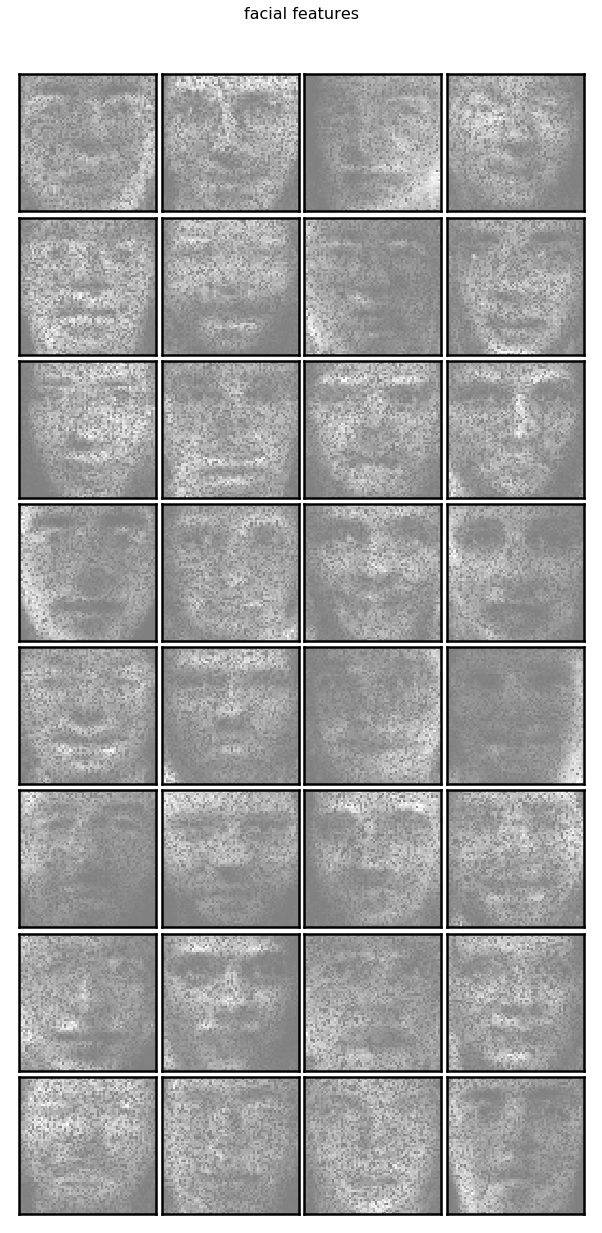

In [114]:
a= my_NMF(n_components=32,epsilon=1,init='random')
b= a.fit_transform(faces)

image_shape=(64,64)
plot_faces("facial features", b[1], image_shape)

here are the main facial feature matrix W (computed with random initialization)

here also are the first 32 faces approximated 

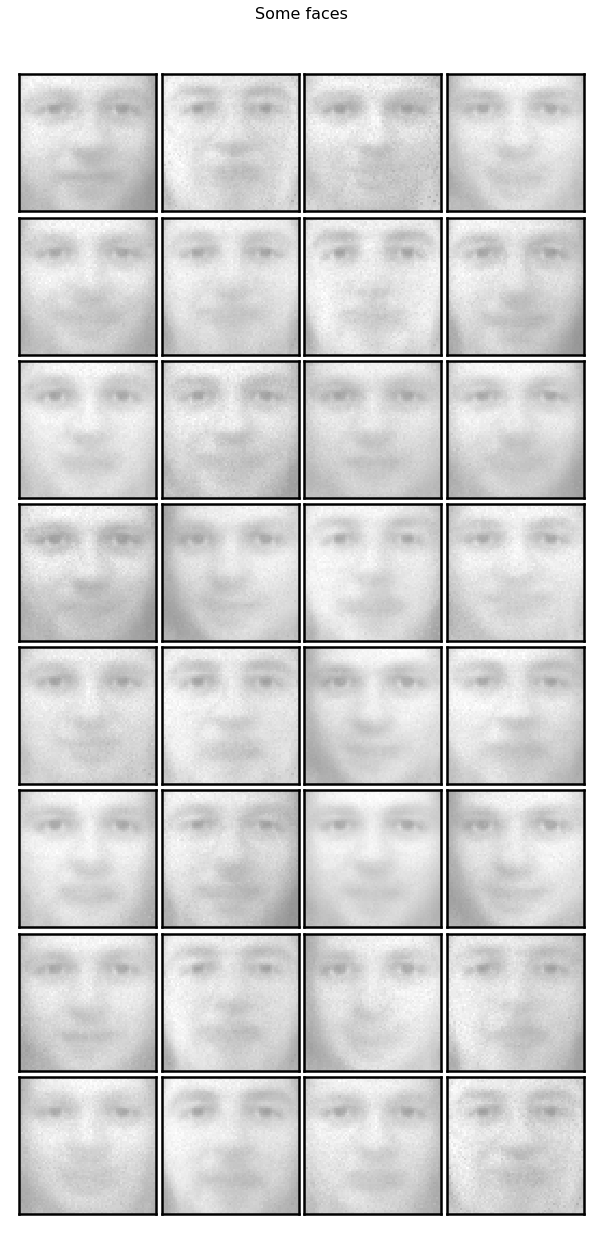

In [115]:
a=b[0]@b[1]
plot_faces("Some faces", a[:32], image_shape)

as you can see those faces are more blurred and noised (the final loss will for sure be bigger than the case seen with NNDSVD initialization

<b> the final loss in this case is</b>:

In [116]:
b[2]

29.60917854894533

almost 3 time the final loss obtained with the NNDSVD initialisation

### Tasks :  
- Apply NMF with the SVD initialisation and with a number of components r such as $\sqrt r$ is an integer (r = 4,16,etc..) 
- Plot the $H$ matrix as images in a $(\sqrt{r}, \sqrt{r})$ grid ( n_col=n_row=$\sqrt r $)
- Choose one face, plot its corresponding weights (in $W$) in a grid 
- How can we interpret the matrices H and W.

Be careful with the arguments image_shape, n_col n_row in the plot_faces function

lets use as r 16 and the nnsvd as starting matrices w and h 

In [117]:
a= my_NMF(n_components=16,epsilon=1,init='NNDSVD')
b= a.fit_transform(faces)

image_shape=(64,64)


the matrix H in the examplw, that as written before represent the main 16 face features in the dataset 

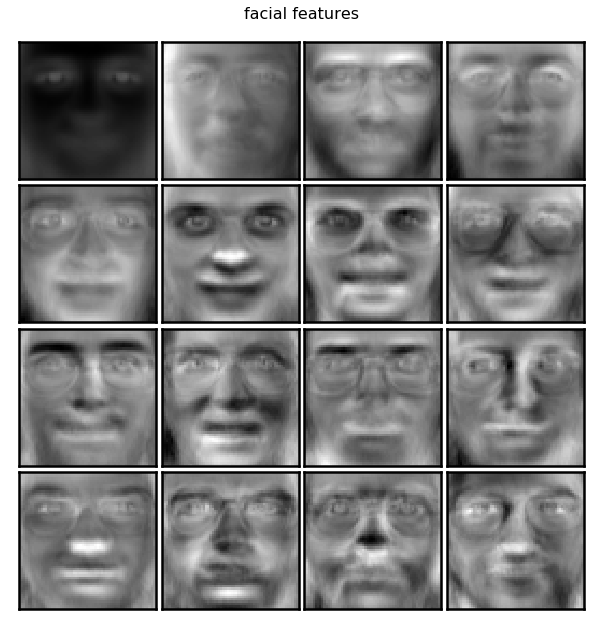

In [119]:
plot_faces("facial features", b[1], image_shape,n_row=4,n_col=4)

lets take the first face:

In [129]:
b[0][0]

array([-0.04952175,  0.06326541,  0.04500163,  0.03212825,  0.02608597,
        0.02640943, -0.02450121,  0.04773533, -0.0755282 ,  0.02816873,
       -0.06499695,  0.04865018, -0.02225885,  0.01526032, -0.11036564,
       -0.07506046])

In [130]:
f=b[0][0]

each value represent the weight given to each of the 16 facial features for image 1 

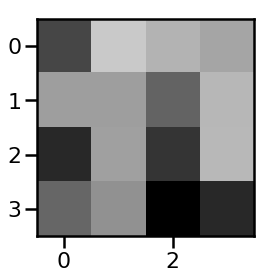

In [133]:
image_shape=(4,4)
vmax = max(f.max(), -f.min())
plt.imshow(f.reshape(image_shape), cmap=plt.cm.gray,interpolation='nearest',vmin=-vmax, vmax=vmax)

this is the reduced first face, each pixel in this representation represent the weight it gives to the corresponding feature represented in the previous plot

### Second application

Import the 20newsgroups dataset (from sklearn.datasets import fetch_20newsgroups_vectorized) that contains a collection of ~18,000 news documents from 20 different newsgroups (i.e 20 different topics like art news, geopolitical news etc...)

The goal of this exercice is to model the topics present with NMF then print the most common words of each topic.

In [63]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.datasets import fetch_20newsgroups

n_samples = 5000
n_features = 2000
n_components = 10
n_top_words = 20

def print_top_words(D, feature_names, n_top_words):
    p, r = D.shape
    for topic_idx in range(r):
        topic = D[:, topic_idx]
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]]) #best 20 word for each topic (best is the best 20 that have the highers tfidf_score per topic)
        print(message)
    print()

dataset = fetch_20newsgroups(shuffle=True, random_state=1,
                             remove=('headers', 'footers', 'quotes'))
data_samples = dataset.data[:n_samples]


print(data_samples[:3]) # A few exemple of news 

["Well i'm not sure about the story nad it did seem biased. What\nI disagree with is your statement that the U.S. Media is out to\nruin Israels reputation. That is rediculous. The U.S. media is\nthe most pro-israeli media in the world. Having lived in Europe\nI realize that incidences such as the one described in the\nletter have occured. The U.S. media as a whole seem to try to\nignore them. The U.S. is subsidizing Israels existance and the\nEuropeans are not (at least not to the same degree). So I think\nthat might be a reason they report more clearly on the\natrocities.\n\tWhat is a shame is that in Austria, daily reports of\nthe inhuman acts commited by Israeli soldiers and the blessing\nreceived from the Government makes some of the Holocaust guilt\ngo away. After all, look how the Jews are treating other races\nwhen they got power. It is unfortunate.\n", "\n\n\n\n\n\n\nYeah, do you expect people to read the FAQ, etc. and actually accept hard\natheism?  No, you need a little leap 

In [29]:
data_samples[1]

"\n\n\n\n\n\n\nYeah, do you expect people to read the FAQ, etc. and actually accept hard\natheism?  No, you need a little leap of faith, Jimmy.  Your logic runs out\nof steam!\n\n\n\n\n\n\n\nJim,\n\nSorry I can't pity you, Jim.  And I'm sorry that you have these feelings of\ndenial about the faith you need to get by.  Oh well, just pretend that it will\nall end happily ever after anyway.  Maybe if you start a new newsgroup,\nalt.atheist.hard, you won't be bummin' so much?\n\n\n\n\n\n\nBye-Bye, Big Jim.  Don't forget your Flintstone's Chewables!  :) \n--\nBake Timmons, III"

### Feature extraction/engineering 

Before applying NMF, you have to convert text into numerical values in order to vectorize your documents.

We will be looking at the Count vectorizer method and the TF-IDF vectorizer.

### Count vectorizer. 
https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

We define a corpus by an ensemble of documents $(D_1,...D_N)$. From this corpus we collect all the different words used in the documents, this collection of words $(w_1,...w_p)$ is called the vocabulary of the corpus.

Using the count vectorizer, the numerical representation of a document $D_i$ will be Count_Vectoriser$(D_i) = \sum_{j=1}^p f_{ij}w_j $ With f_ij, the frequency of appearence of the word $w_j$ in the document $i$.

### TF-IDF

Task : Search for TF-IDF. Explain its principle and its difference with count_vectorizer

Answer : 



both count vectorizer and tf-idf are word vectorization techniques. 
These are techniques that permit to convert a list of different documents in a numerical matrix, in this way we could actually do data analysis on it.
with count vectoriser  a collection of text documents will be converted to a matrix of token counts. each rows represent a document and each column a word in the dictionary,exacly it will represent how much times that word is present in that particular document.
tf- idf instead is a  score represents the relative importance of a term in the document and the entire corpus ( TF stands for term frequency, IDF for inverse document frequency) so for each document and each term  the TFIDF score ( word level) is computed as follows:
$$TFIDF(t,d)=TF(t,d)*log⁡(N/DF(t))$$ 
in which 
$t$:term(a word in the document) 
$d$:document 
$TF$:term frequency(how many times a term t appears in the document d) 
$N$:total number of documents in the corpus  
$DF$:document frequency(number of documents in the corpus containing the term t  
The TF-IDF score could be computed on different levels:
	- Word level: matrix where each row is a document and each column is a term(word) in the corpus, each cell is the TF-IDF score for the word (i,d) 
	- N-gram level: each row is a document and each column is a combination of N terms ( N-grams)
	- Character level: each row is a document, each column is a combination of characters ( n-grams) in the corpus


### Task : Vectorize your document with Count Vectorizer or TF-IDF. 
#### Put in argument stop_words='english'  and max_features=n_features 
Stop_words is a list of common words that don't bring any information like 'the', 'a' etc... We don't want these words to take up space in our database for computation time reason and because they could harm the numerical representation of the documents. 

You must obtain a $5000\times2000$ shaped matrix 

lets firs use tf_idf vectoriser to convert the articles into vectors

In [64]:
# TODO

vectorizer = TfidfVectorizer(stop_words='english',max_features=n_features) #the dictionary will be created only on the top 2000 words (top 2000 words in order of frequency)
X = vectorizer.fit_transform(data_samples)




there are 2000 different words:

In [65]:
len(vectorizer.get_feature_names())

2000

In [66]:
g=vectorizer.get_feature_names()

In [67]:
g

['00',
 '000',
 '01',
 '02',
 '04',
 '05',
 '06',
 '0d',
 '10',
 '100',
 '1000',
 '11',
 '12',
 '120',
 '128',
 '13',
 '130',
 '14',
 '145',
 '15',
 '150',
 '16',
 '16m',
 '17',
 '18',
 '19',
 '1988',
 '1989',
 '1990',
 '1991',
 '1992',
 '1993',
 '1d9',
 '1st',
 '1t',
 '20',
 '200',
 '21',
 '22',
 '23',
 '24',
 '25',
 '250',
 '256',
 '26',
 '27',
 '28',
 '29',
 '2d',
 '2di',
 '2nd',
 '30',
 '300',
 '31',
 '32',
 '33',
 '34',
 '34u',
 '35',
 '36',
 '37',
 '38',
 '386',
 '39',
 '3d',
 '3rd',
 '40',
 '400',
 '41',
 '42',
 '43',
 '44',
 '45',
 '46',
 '47',
 '48',
 '486',
 '49',
 '50',
 '500',
 '51',
 '52',
 '53',
 '54',
 '55',
 '56',
 '57',
 '58',
 '59',
 '5u',
 '60',
 '600',
 '61',
 '63',
 '64',
 '65',
 '66',
 '68',
 '6g',
 '70',
 '71',
 '72',
 '73',
 '75',
 '75u',
 '76',
 '77',
 '79',
 '7u',
 '80',
 '800',
 '81',
 '84',
 '85',
 '86',
 '87',
 '88',
 '89',
 '90',
 '91',
 '92',
 '93',
 '95',
 '99',
 '__',
 '_____',
 'a86',
 'ability',
 'able',
 'absolute',
 'absolutely',
 'ac',
 'academic',

In [68]:
X

<5000x2000 sparse matrix of type '<class 'numpy.float64'>'
	with 167813 stored elements in Compressed Sparse Row format>


### Task : Apply NMF from sklearn with a choosen initialization. Then print the top words for each topics with print_top_words

Use tfidf_vectorizer.get_feature_names() to recover the words. 

In [69]:
from sklearn.decomposition import NMF

in this matrix H each row is a topic and each column is the tdidf score of a word in topic i 

In [71]:
model = NMF(n_components, init='random', random_state=0)
W = model.fit_transform(X)
H = model.components_

np.shape(H)


(10, 2000)

the function print top word have some error: here is fixed:

here is the top 20 words for each topic (10 topic by definition)

In [72]:
def print_top_words(D, feature_names, n_top_words):
    p, r = D.shape
    for topic_idx in range(p):
        topic = D[topic_idx,:]
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]]) #best 20 word for each topic (best is the best 20 that have the highers tfidf_score per topic)
        print(message)
    print()

In [73]:
print_top_words(H, g, n_top_words)

Topic #0: just don like think good ve car really ll got want thing know time going way bike right little sure
Topic #1: does know anybody appreciated program card doesn long info mean say help exactly read work don able deal company needs
Topic #2: god jesus bible faith christians christ christian believe church lord heaven life love say father son true sin belief truth
Topic #3: thanks mail advance hi email looking info com information interested post send help address list reply appreciated need hello anybody
Topic #4: windows file dos use files program problem using window screen running card pc drivers ms application run graphics memory server
Topic #5: drive 00 scsi disk hard drives sale new power card ide controller price floppy shipping offer 10 monitor cd 50
Topic #6: key chip encryption keys clipper government use escrow data law security phone public enforcement nsa algorithm bit encrypted secure number
Topic #7: game team year games play players season hockey league win nhl 

The relevance of the topics can be improved with better parameters in the vectorizer, a more advanced cleaning in addition to the stopwords (for instance getting rid of the numbers etc ...) or more advanced vectorizer/encoder like Word2Vec or Doc2Vec which use very simple neural networks. 

In [74]:
np.shape(W)

(5000, 10)

### Imagine we would like to gather the news coming from the same newsgroup/news category. How would you do using the NMF and the previous courses ? 

Answer :


the advantage of using NMF for topic modeling is that, using this method we are not only able to identify what are the main k topics in the documents but also to assign a topic for each model.
For example lets imagine a situation in wich we want to assign a single topic to each document.
When we apply the nmf method we are able to identify a list of the main k topics, plus with the help of the matrix W we are able to identify the importance of each topic in every document, so assigning a topic to each document its trivial, it's topic is infact its  most important topic(taken from matrix w).
once we assigned the most important topic of  each document as it's "topic" we can just get all the documents that belongs to a particular topic to answer the question asked in this lab 

### Implement your solution.

since we know that there are 20 caegories in total we can fix r = 20

In [82]:
n_components=20
model = NMF(n_components, init='random', random_state=0)
W = model.fit_transform(X)
H = model.components_

np.shape(H)

(20, 2000)

In [83]:
g=vectorizer.get_feature_names()

In [84]:
print_top_words(H, g, n_top_words)

Topic #0: don think know want people mean really need wrong little statement better pretty care understand read believe hope things bible
Topic #1: com article ibm hp sun list bob vice stay internet dave away mail email stuff tell att faq reply said
Topic #2: like good time right ll did going really way didn say make thing long course bike problem years doesn let
Topic #3: thanks mail advance hi info looking email information help post interested know appreciated address send reply anybody hello need appreciate
Topic #4: ve got seen heard tried using best try gun used explain recently stick times gotten better line okay output number
Topic #5: drive scsi hard drives disk ide floppy controller power cd mac internal rom external mb motherboard hd boot meg bios
Topic #6: windows file dos files program ms problem running run os swap using directory ftp version problems win copy nt manager
Topic #7: game team games year play players season hockey league win nhl teams player baseball runs to

In [85]:
np.shape(W)

(5000, 20)

In [92]:
np.argmax(W[39])

3

In [95]:
topics={}
p,q=np.shape(W)
for i in range(p):
    index=np.argmax(W[i])
    topics[i]=index
    print("the article "+str(i)+" has topic "+str(index))
    

the article 0 has topic 14
the article 1 has topic 0
the article 2 has topic 14
the article 3 has topic 11
the article 4 has topic 2
the article 5 has topic 0
the article 6 has topic 9
the article 7 has topic 2
the article 8 has topic 0
the article 9 has topic 2
the article 10 has topic 8
the article 11 has topic 9
the article 12 has topic 8
the article 13 has topic 15
the article 14 has topic 0
the article 15 has topic 8
the article 16 has topic 11
the article 17 has topic 7
the article 18 has topic 11
the article 19 has topic 15
the article 20 has topic 2
the article 21 has topic 18
the article 22 has topic 2
the article 23 has topic 14
the article 24 has topic 7
the article 25 has topic 15
the article 26 has topic 1
the article 27 has topic 11
the article 28 has topic 7
the article 29 has topic 2
the article 30 has topic 11
the article 31 has topic 2
the article 32 has topic 2
the article 33 has topic 15
the article 34 has topic 14
the article 35 has topic 0
the article 36 has topic

the article 1123 has topic 11
the article 1124 has topic 0
the article 1125 has topic 0
the article 1126 has topic 14
the article 1127 has topic 2
the article 1128 has topic 19
the article 1129 has topic 10
the article 1130 has topic 7
the article 1131 has topic 1
the article 1132 has topic 16
the article 1133 has topic 7
the article 1134 has topic 5
the article 1135 has topic 15
the article 1136 has topic 19
the article 1137 has topic 0
the article 1138 has topic 6
the article 1139 has topic 2
the article 1140 has topic 0
the article 1141 has topic 2
the article 1142 has topic 0
the article 1143 has topic 2
the article 1144 has topic 14
the article 1145 has topic 11
the article 1146 has topic 6
the article 1147 has topic 2
the article 1148 has topic 1
the article 1149 has topic 15
the article 1150 has topic 15
the article 1151 has topic 10
the article 1152 has topic 15
the article 1153 has topic 2
the article 1154 has topic 15
the article 1155 has topic 15
the article 1156 has topic 6

the article 2122 has topic 0
the article 2123 has topic 13
the article 2124 has topic 18
the article 2125 has topic 2
the article 2126 has topic 11
the article 2127 has topic 2
the article 2128 has topic 2
the article 2129 has topic 9
the article 2130 has topic 0
the article 2131 has topic 16
the article 2132 has topic 2
the article 2133 has topic 14
the article 2134 has topic 2
the article 2135 has topic 13
the article 2136 has topic 2
the article 2137 has topic 6
the article 2138 has topic 2
the article 2139 has topic 1
the article 2140 has topic 5
the article 2141 has topic 0
the article 2142 has topic 14
the article 2143 has topic 3
the article 2144 has topic 0
the article 2145 has topic 13
the article 2146 has topic 9
the article 2147 has topic 15
the article 2148 has topic 11
the article 2149 has topic 5
the article 2150 has topic 9
the article 2151 has topic 18
the article 2152 has topic 0
the article 2153 has topic 18
the article 2154 has topic 0
the article 2155 has topic 8
th

the article 2950 has topic 6
the article 2951 has topic 15
the article 2952 has topic 5
the article 2953 has topic 2
the article 2954 has topic 5
the article 2955 has topic 18
the article 2956 has topic 0
the article 2957 has topic 0
the article 2958 has topic 9
the article 2959 has topic 2
the article 2960 has topic 3
the article 2961 has topic 7
the article 2962 has topic 2
the article 2963 has topic 4
the article 2964 has topic 7
the article 2965 has topic 18
the article 2966 has topic 11
the article 2967 has topic 15
the article 2968 has topic 2
the article 2969 has topic 16
the article 2970 has topic 0
the article 2971 has topic 11
the article 2972 has topic 10
the article 2973 has topic 15
the article 2974 has topic 8
the article 2975 has topic 0
the article 2976 has topic 1
the article 2977 has topic 19
the article 2978 has topic 2
the article 2979 has topic 8
the article 2980 has topic 16
the article 2981 has topic 14
the article 2982 has topic 16
the article 2983 has topic 0
t

the article 3800 has topic 0
the article 3801 has topic 14
the article 3802 has topic 13
the article 3803 has topic 4
the article 3804 has topic 13
the article 3805 has topic 16
the article 3806 has topic 0
the article 3807 has topic 10
the article 3808 has topic 2
the article 3809 has topic 9
the article 3810 has topic 11
the article 3811 has topic 12
the article 3812 has topic 0
the article 3813 has topic 14
the article 3814 has topic 6
the article 3815 has topic 3
the article 3816 has topic 7
the article 3817 has topic 14
the article 3818 has topic 12
the article 3819 has topic 3
the article 3820 has topic 9
the article 3821 has topic 16
the article 3822 has topic 0
the article 3823 has topic 2
the article 3824 has topic 2
the article 3825 has topic 10
the article 3826 has topic 10
the article 3827 has topic 2
the article 3828 has topic 13
the article 3829 has topic 19
the article 3830 has topic 8
the article 3831 has topic 7
the article 3832 has topic 16
the article 3833 has topic 

the article 4621 has topic 5
the article 4622 has topic 1
the article 4623 has topic 14
the article 4624 has topic 2
the article 4625 has topic 2
the article 4626 has topic 10
the article 4627 has topic 0
the article 4628 has topic 7
the article 4629 has topic 0
the article 4630 has topic 16
the article 4631 has topic 2
the article 4632 has topic 8
the article 4633 has topic 0
the article 4634 has topic 14
the article 4635 has topic 0
the article 4636 has topic 15
the article 4637 has topic 4
the article 4638 has topic 0
the article 4639 has topic 9
the article 4640 has topic 11
the article 4641 has topic 3
the article 4642 has topic 2
the article 4643 has topic 8
the article 4644 has topic 1
the article 4645 has topic 0
the article 4646 has topic 0
the article 4647 has topic 0
the article 4648 has topic 14
the article 4649 has topic 1
the article 4650 has topic 4
the article 4651 has topic 13
the article 4652 has topic 19
the article 4653 has topic 14
the article 4654 has topic 0
the 

for example the first article is mainly about the israly war or something related to geopolitic (topic 14)

to gather all documents of topic 15 for example ( cristianity) we only need to :

In [97]:
articles_cristianity=[k for k,v in topics.items() if v==15]

In [99]:
print(articles_cristianity)

[13, 19, 25, 33, 79, 88, 95, 186, 207, 221, 222, 272, 284, 290, 313, 339, 497, 503, 510, 544, 559, 597, 624, 643, 647, 678, 727, 762, 767, 800, 801, 808, 812, 843, 849, 860, 909, 1024, 1026, 1032, 1037, 1066, 1097, 1109, 1135, 1149, 1150, 1152, 1154, 1155, 1174, 1177, 1216, 1229, 1233, 1335, 1337, 1370, 1456, 1466, 1496, 1500, 1520, 1566, 1586, 1591, 1593, 1633, 1678, 1725, 1734, 1740, 1750, 1770, 1775, 1804, 1852, 1959, 1960, 1998, 2009, 2063, 2147, 2159, 2182, 2256, 2317, 2322, 2341, 2367, 2394, 2395, 2432, 2442, 2492, 2510, 2514, 2529, 2554, 2589, 2590, 2605, 2609, 2615, 2653, 2676, 2678, 2693, 2702, 2750, 2760, 2766, 2789, 2800, 2904, 2908, 2911, 2928, 2951, 2967, 2973, 3007, 3058, 3071, 3086, 3116, 3175, 3179, 3195, 3207, 3219, 3238, 3257, 3258, 3283, 3445, 3490, 3499, 3539, 3563, 3575, 3608, 3642, 3644, 3651, 3690, 3694, 3727, 3742, 3758, 3766, 3858, 3862, 3876, 3879, 3907, 3915, 3932, 3960, 3963, 3973, 3987, 3990, 4006, 4025, 4049, 4077, 4119, 4130, 4243, 4259, 4317, 4344, 4374,

those are the indices of the articles about cristianity.

To get the first article  for example:

In [101]:
data_samples[articles_cristianity[0]]

'Hi Damon,  No matter what system or explanation of creation you wish\nto accept, you always have to start with one of two premises, creation\nfrom nothing, or creation from something.  There are no other\nalternatives.  And if we accept one or the other of those two\npremises, then again there are two alternatives, either creation was\nrandom, or was according to some plan.\n   If it was random, I am unable to accept that the complex nature of\nour world with interrelated interdependent organisms and creatures\ncould exist as they do.  Therefore I am left with creation under the\ncontrol of an intelligence capable of devising such a scheme.  I call\nthat intelligence God.\n   I also prefer the "Creatio ex nihilo" rather than from chaos, as it\nis cleaner.\n   There is obviously no way to prove either or neither.  We are and\nwe must have come from somewhere.  Choose whatever explanation you\nfeel most comfortable with, Damon.  You are the one who has to live\nwith your choice.\nShalom